In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import tensorflow as tf
import glob
import pickle
import keras.utils as image
from numpy import array
from keras.layers import LSTM, Embedding, Dense, concatenate, Dropout,Input
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model,load_model
from keras.applications.inception_v3 import preprocess_input
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from nltk.translate.bleu_score import corpus_bleu


In [15]:

def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text
    
  
def load_descriptions(doc):
    mapping = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        if len(line) < 2:
            continue
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0]
        image_desc = ' '.join(image_desc)
        if image_id not in mapping:
            mapping[image_id] = list()
        mapping[image_id].append(image_desc)
    return mapping
  
def clean_descriptions(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()
            desc = [word.lower() for word in desc]
            desc = [w.translate(table) for w in desc]
            desc = [word for word in desc if len(word)>1]
            desc = [word for word in desc if word.isalpha()]
            desc_list[i] =  ' '.join(desc)
            
    return descriptions

# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()


def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions
  
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)


filename = "Flickr8k_text/Flickr8k.token.txt"
doc = load_doc(filename)
descriptions = load_descriptions(doc)
descriptions = clean_descriptions(descriptions)
save_descriptions(descriptions, 'descriptions.txt')
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
filenameTest = 'Flickr8k_text/Flickr_8k.testImages.txt'
train = load_set(filename)
test = load_set(filenameTest)
train_descriptions = load_clean_descriptions('descriptions.txt', train)
test_descriptions = load_clean_descriptions('descriptions.txt', test)
test_descriptions

{'1056338697_4f7d7ce270': ['startseq blond woman in blue shirt appears to wait for ride endseq',
  'startseq blond woman is on the street hailing taxi endseq',
  'startseq woman is signaling is to traffic as seen from behind endseq',
  'startseq woman with blonde hair wearing blue tube top is waving on the side of the street endseq',
  'startseq the woman in the blue dress is holding out her arm at oncoming traffic endseq'],
 '106490881_5a2dd9b7bd': ['startseq boy in his blue swim shorts at the beach endseq',
  'startseq boy smiles for the camera at beach endseq',
  'startseq young boy in swimming trunks is walking with his arms outstretched on the beach endseq',
  'startseq children playing on the beach endseq',
  'startseq the boy is playing on the shore of an ocean endseq'],
 '1082379191_ec1e53f996': ['startseq lady and man with no shirt sit on dock endseq',
  'startseq man and woman are sitting on dock together endseq',
  'startseq man and woman sitting on dock endseq',
  'startseq

In [16]:
# list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
        
# words should occur at least 10 times
word_count_threshold = 10

word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('Preprocessed words {} -> {}'.format(len(word_counts), len(vocab)))


ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1
    
vocab_size = len(ixtoword) + 1 # one for appended 0's

# max length of description in train dataset
max_length = max(len(des.split()) for des in all_train_captions)

with tf.device('/GPU:0'):
    # Load Glove vectors
    embeddings_index = {}
    f = open('glove.6B.200d.txt', encoding="utf-8")

    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    embedding_dim = 200

    # Get 200-dim vector for each word in the vocabulary
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, i in wordtoix.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Preprocessed words 7578 -> 1651


In [23]:
from pickle import load

all_images_path = 'Flickr8k_Dataset/Flicker8k_Dataset/'
# Create a list of all image names in the directory
all_images = glob.glob(all_images_path + '*.jpg')

# list of all the training and testing images
def create_list_of_images(file_path):
  image_names = set(open(file_path, 'r').read().strip().split('\n'))
  images = []

  for image in all_images: 
      if image[len(all_images_path):] in image_names:
          images.append(image)
  
  return images


train_images_path = 'Flickr8k_text/Flickr_8k.trainImages.txt'
test_images_path = 'Flickr8k_text/Flickr_8k.testImages.txt'

train_images = create_list_of_images(train_images_path)
test_images = create_list_of_images(test_images_path)

#preprocessing the images
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x) #pre-process for inceptionv3 pre-trained model
    return x

#preprocessing the images
def preprocess2(picture):
    x = image.img_to_array(picture)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x) #pre-process for inceptionv3 pre-trained model
    return x

# Load the inception v3 model
model = InceptionV3(weights='imagenet')

# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)
#print(model_new.summary())

# Encoding a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) 
    #print(image)
    #print("********************************")
    fea_vec = model_new.predict(image) 
    #print(fea_vec)
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    #print('-----------------------------------------')
    #print(fea_vec)
    return fea_vec

def encode2(picture):
    image = preprocess2(picture) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec
  

#encode('Flickr8k_Dataset/Flicker8k_Dataset/1007320043_627395c3d8.jpg')


In [24]:
with tf.device('/GPU:0'): 
    encoding_train = {}
    for img in train_images:
        encoding_train[img[len(all_images_path):]] = encode(img)
        
        
    encoding_test = {}
    for img in test_images:
        encoding_test[img[len(all_images_path):]] = encode(img)
    
# Save the intensive features to disk
with open("encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)
    
with open("encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)
    
train_features = load(open("encoded_train_images.pkl", "rb"))

1/1 [==============================] - 0s 24ms/step


In [25]:
# data generator, to process images in batches to reserve memory
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence one-hot similar
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [26]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)
decoder1 = concatenate([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

model.compile(loss='categorical_crossentropy', optimizer='adam')

print(model.summary())

# tf.debugging.set_log_device_placement(True)


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 34)]         0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 34, 200)      330400      ['input_10[0][0]']               
                                                                                                  
 dropout_6 (Dropout)            (None, 2048)         0           ['input_9[0][0]']                
                                                                                            

In [27]:
epochs = 40
number_pics_per_batch = 30
steps = len(train_descriptions)//number_pics_per_batch

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
history = model.fit(generator, epochs=epochs,  steps_per_epoch=steps, verbose=1)


model.optimizer.lr = 0.0001
epochs = 30
number_pics_per_batch = 60
steps = len(train_descriptions)//number_pics_per_batch

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
history1 = model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

model.save('saved_model/model_' + str(70) + '.h5')

Epoch 1/40
200/200 [==============================] - 55s 262ms/step - loss: 4.6952
Epoch 2/40
200/200 [==============================] - 64s 317ms/step - loss: 3.7862
Epoch 3/40
200/200 [==============================] - 63s 316ms/step - loss: 3.4691
Epoch 4/40
200/200 [==============================] - 63s 314ms/step - loss: 3.2841
Epoch 5/40
200/200 [==============================] - 63s 313ms/step - loss: 3.1562
Epoch 6/40
200/200 [==============================] - 63s 314ms/step - loss: 3.0576
Epoch 7/40
200/200 [==============================] - 63s 315ms/step - loss: 2.9737
Epoch 8/40
200/200 [==============================] - 63s 314ms/step - loss: 2.9038
Epoch 9/40
200/200 [==============================] - 64s 319ms/step - loss: 2.8403
Epoch 10/40
200/200 [==============================] - 63s 313ms/step - loss: 2.7850
Epoch 11/40
200/200 [==============================] - 63s 315ms/step - loss: 2.7349
Epoch 12/40
200/200 [==============================] - 63s 315ms/step - lo

In [28]:
def showCaption(photo):
    image = encode2(photo)
    image = image.reshape(1,2048)
    model = load_model('saved_model/model_70.h5')
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([image,sequence], verbose=1)
        pred = np.argmax(pred)
        word = ixtoword[pred]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

def captionEvaluate(photo):
    # image = encode2(photo)
    image = photo.reshape(1,2048)
    model = load_model('saved_model/model_70.h5')
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([image,sequence], verbose=1)
        pred = np.argmax(pred)
        word = ixtoword[pred]
        in_text += ' ' + word
        if word == 'endseq':
            break
    # final = in_text.split()
    # final = final[1:-1]
    # final = ' '.join(final)
    return in_text


# pic = list(encoding_test.keys())[999]
# print(pic)
# image = encoding_test[pic].reshape((1,2048))
# print(image)
# x=plt.imread('Flickr8k_Dataset/Flicker8k_Dataset/' + pic)
# plt.imshow(x)
# plt.show()
# print(greedySearch(image))

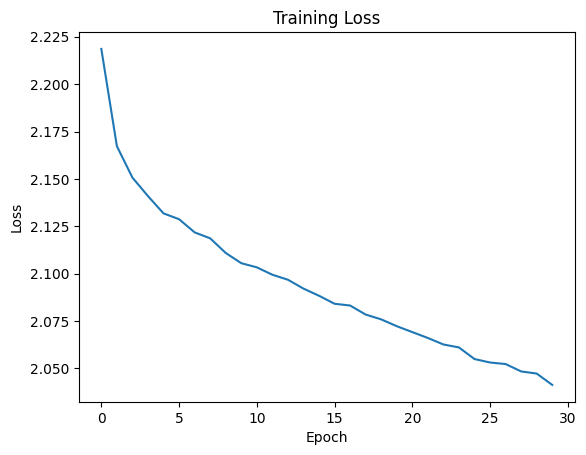

1/1 [==============================] - 0s 47ms/step


In [ ]:
plt.plot(history1.history['loss'])
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [30]:
actual, predicted = [], []
#print(encoding_test)
for test_img_name in encoding_test:
    pic = encoding_test[test_img_name]
    estimated_caption = captionEvaluate(pic)

    captions = [caption.split() for caption in test_descriptions[test_img_name.split('.')[0]]]
    
    # store actual and predicted
    actual.append(captions)
    predicted.append(estimated_caption.split())


1/1 [==============================] - 0s 47ms/step


In [33]:
print(actual[112])
print("----------------------------------")
print(predicted[112])

# Print BLEU score
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

[['startseq', 'man', 'and', 'child', 'stand', 'at', 'the', 'bottom', 'of', 'an', 'outdoor', 'staircase', 'near', 'benches', 'endseq'], ['startseq', 'man', 'and', 'young', 'boy', 'are', 'standing', 'looking', 'at', 'each', 'other', 'in', 'an', 'outdoor', 'garden', 'area', 'endseq'], ['startseq', 'man', 'in', 'an', 'ampitheater', 'talking', 'to', 'boy', 'endseq'], ['startseq', 'man', 'talks', 'to', 'boy', 'in', 'vacant', 'area', 'endseq'], ['startseq', 'the', 'man', 'and', 'the', 'boy', 'are', 'standing', 'at', 'the', 'bottom', 'of', 'the', 'outdoor', 'stairs', 'endseq']]
----------------------------------
['startseq', 'two', 'children', 'are', 'playing', 'on', 'the', 'sidewalk', 'near', 'large', 'endseq']
BLEU-1: 0.574640
BLEU-2: 0.351776
BLEU-3: 0.258654
BLEU-4: 0.136032


In [34]:
import gradio as gr

gr.Interface(fn=showCaption, 
             inputs=gr.Image(shape=(299, 299)),
             outputs="text").launch()

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.
